* Slanted 25
* Slanted 50
* Slanted 100
---
* Straight 25
* Straight 50
* Straight 100

## 1. Generate masks

The following pieces of code create masks that allow for a quick way to check on which stripe a given (x,y) position of a nucleus is.

### Slanted mask

A slanted mask accounts for the curvature of the border. Every stripe maintains the shape of the border and has a constant width through all its height. The limits of these stripes can be seen as translations of the border to the left.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Image, Int, Int -> Array

# Takes an image in its final binary mapping version, that is,
# an image with a black background and a white line of width 1 px,
# which is well defined for all y (each row has exactly one white pixel).

# Returns a numpy array that acts as a mask of the stripes.
# The stripes are defined and indexed from right to left, with an offset
# from the border to avoid noise.

# Each value in the returned matrix is one of the following:
# -2 means background,
# -1 means offset (to avoid noise close to border),
# 0, 1, 2, 3, ... mean the index of the stripe, from right to left.

# mapping_image: image in mapping version, of type Pillow Image
# offset: number of pixels from border to be ignored
# delta_x: pixel width of stripes

def get_mask(mapping_image, offset, delta_x):
    # Convert image to values in array.
    mapping_array = np.array(mapping_image)
    height = mapping_array.shape[0]
    width = mapping_array.shape[1]

    # Initially, mask is completely undefined (-3).
    mask_array = np.full((height, width), -3)

    # Iterate over each row of the image:
    for row in range(height):

        STATE = 'OUTSIDE'
        i = offset
        j = delta_x
        stripe_idx = 0

        # Iterate over each pixel in the row, from right to left:
        for col in reversed(range(width)):

            # While in the background, outside of the tissue.
            if STATE == 'OUTSIDE':
                if mapping_array[row, col] == 0:
                    mask_array[row][col] = -2
                else: # White pixel of border found
                    STATE = 'OFFSET'
                    mask_array[row][col] = -1

            # While inside the offset inside of the tissue.
            elif STATE == 'OFFSET':
                if i > 0:
                    mask_array[row][col] = -1
                    i -= 1
                else: # Offset required width is satisfied
                    STATE = 'STRIPES'
                    mask_array[row][col] = 0

            # While inside an arbitrary stripe inside of the tissue.
            elif STATE == 'STRIPES':
                if j > 0:
                    mask_array[row][col] = stripe_idx
                    j -= 1
                else: # Stripe required width is satisfied
                    stripe_idx += 1
                    mask_array[row][col] = stripe_idx
                    j = delta_x

    return mask_array

### Straight mask

A straight mask does not account for the curvature of the border. Instead, a vertical approximation is used. Every stripe is a rectangle.

In [50]:
# Image, Int, Int -> Array

# Takes an image in its final binary mapping version, that is,
# an image with a black background and a white line of width 1 px,
# which is well defined for all y (each row has exactly one white pixel).

# Returns a numpy array that acts as a mask of the stripes.
# The stripes are defined and indexed from right to left, with an offset
# from the border to avoid noise.

# Each value in the returned matrix is one of the following:
# -2 means background,
# -1 means offset (to avoid noise close to border),
# 0, 1, 2, 3, ... mean the index of the stripe, from right to left.

# mapping_image: image in mapping version, of type Pillow Image
# offset: number of pixels from border to be ignored
# delta_x: pixel width of stripes

def get_mask(mapping_image, offset, delta_x):
    # Convert image to values in array.
    mapping_array = np.array(mapping_image)
    height = mapping_array.shape[0]
    width = mapping_array.shape[1]

    # Find the position of the leftmost white pixel:
    found = False
    lmw_col = -1
    for col in range(width):
        if not found:
            for row in range(height):
                if mapping_array[row, col] != 0:
                    lmw_col = col
                    found = True
                    break

    # Initially, mask is completely undefined (-3).
    mask_array = np.full((height, width), -3)

    # Iterate over each row of the image:
    for row in range(height):

        STATE = 'OUTSIDE'
        i = offset
        j = delta_x
        stripe_idx = 0

        # Iterate over each pixel in the row, from right to left:
        for col in reversed(range(width)):

            # While in the background, outside of the tissue.
            if STATE == 'OUTSIDE':
                if col > lmw_col:
                    mask_array[row][col] = -2
                else: # Border found
                    STATE = 'OFFSET'
                    mask_array[row][col] = -1

            # While inside the offset inside of the tissue.
            elif STATE == 'OFFSET':
                if i > 0:
                    mask_array[row][col] = -1
                    i -= 1
                else: # Offset required width is satisfied
                    STATE = 'STRIPES'
                    mask_array[row][col] = 0

            # While inside an arbitrary stripe inside of the tissue.
            elif STATE == 'STRIPES':
                if j > 0:
                    mask_array[row][col] = stripe_idx
                    j -= 1
                else: # Stripe required width is satisfied
                    stripe_idx += 1
                    mask_array[row][col] = stripe_idx
                    j = delta_x

    return mask_array

### Visualize masks

The following function visualizes the stripes on the given mask array, giving a random color to each of them

In [3]:
# Assigns a random color to each distinct number in a numpy
# matrix and displays the result.
# **This function was completely generated by ChatGPT**
def visualize_mask(mask_array):
    # Generate a random NumPy matrix
    mask_array = mask_array

    # Get the unique numbers in the matrix
    numbers = np.unique(mask_array)

    # Assign a random color to each number
    color_map = {}
    for number in numbers:
        color = np.random.rand(3)
        color_map[number] = color

    # Create a colored image based on the matrix
    image = np.zeros((mask_array.shape[0], mask_array.shape[1], 3))
    for i in range(mask_array.shape[0]):
        for j in range(mask_array.shape[1]):
            number = mask_array[i, j]
            color = color_map[number]
            image[i, j] = color

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## 2. Save masks

The following script uses the primitive skeletonized version of the border from ImageJ and generates and saves the corresponding mask, using the already defined get_mask function. The first and last masks are shown.

Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__1.csv


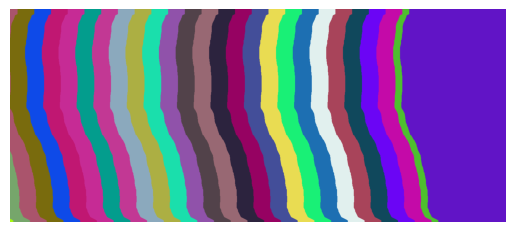

Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__2.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__3.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__4.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__5.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__6.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__7.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__8.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185

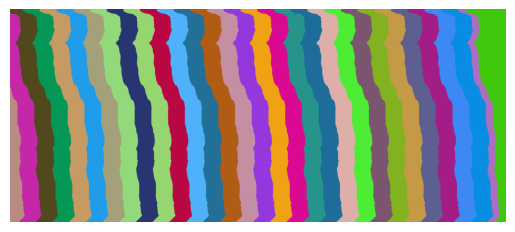

In [4]:
# Given an original skeletonized version of the white border
# on black background from ImageJ, generates and saves the
# 1. binarized version (image)
# 2. mapping version (image)
# 3. mask array (csv)

# In this context, a mapping is an image where EVERY pixel
# in the y dimension (each row) has ONE AND ONLY one white border
# pixel (column) associated in that row.

from PIL import Image
import numpy as np
import os
import pandas as pd

results_border_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/images_final_border/"
results_binarized_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/images_final_binarized/"
results_mapping_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/images_final_mapping/"
results_masks_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/"

offset = 20
delta_x = 50
total_frames = 185

for i in range(1, total_frames+1):
    img_border_name = 'final_border_1_185__' + str(i) + '.png'
    img_binarized_name = 'final_binarized_1_185__' + str(i) + '.png'
    img_mapping_name = 'final_mapping_1_185__' + str(i) + '.png'
    csv_mask_name = 'final_mask_1_185__' + str(i) + '.csv'

    image = Image.open(os.path.join(results_border_dir, img_border_name)).convert('L')

    # Binarize the image.
    binarized_image = image.point(lambda x: 255 if x > 0 else 0, '1')
    binarized_image.save(os.path.join(results_binarized_dir, img_binarized_name))
    binarized_array = np.array(binarized_image)

    # == One white per row ==
    # Iterate over each row of the image
    for row in range(binarized_array.shape[0]):
        found_white_pixel = False

        # Iterate over each pixel in the row
        for col in range(binarized_array.shape[1]):

            if found_white_pixel:
                if binarized_array[row, col] == True:
                    binarized_array[row, col] = 0

            else:
                if binarized_array[row, col] == True:
                    found_white_pixel = True
    # == == == == == == == ==

    # == Every row has one white ==
    # = Patch upper hole =
    found_uppermost_white_pixel = False
    for row in range(binarized_array.shape[0]):

        # Iterate over each pixel in the row
        for col in range(binarized_array.shape[1]):
            
                if binarized_array[row, col] == True:
                    uppermost_white_pixel_col = col
                    uppermost_white_pixel_row = row
                    found_uppermost_white_pixel = True
                    break

        if found_uppermost_white_pixel:
            break

    for row in range(uppermost_white_pixel_row):
        binarized_array[row, uppermost_white_pixel_col] = 1
    # = = = = = = = =

    # = Patch lower hole =
    found_lowermost_white_pixel = False
    for row in reversed(range(binarized_array.shape[0])):

        # Iterate over each pixel in the row
        for col in range(binarized_array.shape[1]):

                if binarized_array[row, col] == True:
                    lowermost_white_pixel_col = col
                    lowermost_white_pixel_row = row
                    found_lowermost_white_pixel = True
                    break

        if found_lowermost_white_pixel:
            break

    for row in reversed(range(lowermost_white_pixel_row, binarized_array.shape[0])):
        binarized_array[row, lowermost_white_pixel_col] = 1
    # = = = = = = = =
        
    # == == == == == == == ==

    mapping_image = Image.fromarray(binarized_array)
    mapping_image.save(os.path.join(results_mapping_dir, img_mapping_name))

    mask_array = get_mask(mapping_image, offset, delta_x)
    np.savetxt(os.path.join(results_masks_dir,csv_mask_name), mask_array, delimiter=',')
    print("Mask saved in "+os.path.join(results_masks_dir,csv_mask_name))

    if i == 1 or i == total_frames:
        visualize_mask(mask_array)

## 3. Velocity data

The following pieces of code allow for the calculation of velocities. These are calculated for different delta_frames. When choosing a value for delta_frames, caution must be taken, as velocities near the end of the video cannot be calculated.

In [10]:
# Given the dataframe extracted from FIJI,
# calculates velocities with a given frame interval,
# and saves it in a dedicated folder for that given time interval.

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

results_masks_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/"
csv_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/data_extracted/"
csv_name = "half185.csv"

time_resolution = 3/60 # 3 minutes between frames, to hours
space_resolution = 1.5 # 1.5 microns per pixel

# Define delta_frames to calculate velocity between frames. 
# Example: if original video is f1 f2 f3 f4 f5 f6 f7 f8 and delta_frames = 3,
# velocity will be calculated between the following frames f1 f4 f7,
# resulting in a total of 2 velocities located in frames f1 and f4.
# Note that f8 is not taken into account.
def get_velocity_data(delta_frames):
    
    results_data_delta_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/data_extracted/velocity_delta/"
    new_csv_name = "velocities_delta_"+str(delta_frames)+".csv"

    df_original = pd.read_csv(os.path.join(csv_dir, csv_name), skiprows=[1, 2, 3])
    df = df_original.copy()
    df = df.sort_values(by=['TRACK_ID', 'FRAME'], ascending=True)
    df = df.reset_index(drop=True)
    df_general = pd.DataFrame(columns=['FRAME','POS_X','POS_Y','VEL_X','VEL_Y','DIFF_T','TRACK_ID'])

    # Iterate over the tracks and generate their dataframe.
    for i in range(0, len(df.TRACK_ID.unique())):
        df_filtered = df[df['TRACK_ID'] == i]
        df_filtered = df_filtered.reset_index(drop=True)
        
        if len(df_filtered) <= delta_frames:
            continue # Do not calculate because it is impossible.

        else:
            # Iterate over the frames (except the last, velocities are undefined here) in the track.
            for j in range(0, len(df_filtered)-delta_frames, delta_frames): # Velocity will be calculated for every frame possible.

                frame = df_filtered['FRAME'][j]
                
                if frame != j:
                    continue

                pos_x = df_filtered['POSITION_X'][j]
                pos_y = df_filtered['POSITION_Y'][j]
                vel_x = (space_resolution/time_resolution) * (1/delta_frames) * (df_filtered['POSITION_X'][j + delta_frames] - df_filtered['POSITION_X'][j])
                vel_y = - (space_resolution/time_resolution) * (1/delta_frames) * (df_filtered['POSITION_Y'][j + delta_frames] - df_filtered['POSITION_Y'][j]) # Fiji inverts y-axis
                diff_t = df_filtered['FRAME'][j + delta_frames] - df_filtered['FRAME'][j]
                track_id = df_filtered['TRACK_ID'][j]

                # Define a tuple to be added to the DataFrame
                new_tuple = (frame, pos_x, pos_y, vel_x, vel_y, diff_t, track_id)
                # Add the tuple to the DataFrame
                df_general.loc[len(df_general)] = new_tuple

    df_general.to_csv(os.path.join(results_data_delta_dir, new_csv_name), index=False)

    print("Dataframe created and saved in "+os.path.join(results_data_delta_dir, new_csv_name))
    print(df_general)

for option in [4]:
    get_velocity_data(delta_frames=option)

Dataframe created and saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/data_extracted/velocity_delta/velocities_delta_12.csv
       FRAME        POS_X       POS_Y      VEL_X      VEL_Y  DIFF_T  TRACK_ID
0        0.0  1114.236909  509.263010  13.744389 -10.256480    12.0       0.0
1       12.0  1119.734664  513.365602   3.339253   1.866692    12.0       0.0
2       24.0  1121.070365  512.618925   3.468275   8.217151    12.0       0.0
3       36.0  1122.457675  509.332064  -5.798359  11.084876    12.0       0.0
4       48.0  1120.138332  504.898114   3.162592  -2.741863    12.0       0.0
...      ...          ...         ...        ...        ...     ...       ...
36528    0.0   903.809979  103.489863   4.430570 -10.467142    13.0    3563.0
36529    0.0   241.304165  140.272679  12.222501 -11.287152    13.0    3574.0
36530    0.0   698.815510  212.507294  17.318138  -9.875177    14.0    3588.0
36531    0.0   820.790421   28.810070   8.401107   8.966994    13.0    

KeyboardInterrupt: 

## 4. Velocity stripes

In [ ]:
# Given the dataframe with the calculated velocities,
# finds the stripe each spot is in to plot
# velocities vs. the index.

import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

results_masks_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/"

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def fit_exponential(data, start_index):
    x = np.arange(len(data))
    y = data[start_index:]
    popt, _ = curve_fit(exponential_func, x[start_index:], y, p0=[17,0.3,14], maxfev=5000)
    return popt

def get_velocity_stripes(delta_frames, stripe_amount):

    data_delta_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/data_extracted/velocity_delta/"
    new_csv_name = "velocities_delta_"+str(delta_frames)+".csv"

    results_plots_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_velocity/velocity_delta_" + str(delta_frames)
    expfit_plots_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_expfit/expfit_delta_" + str(delta_frames)
    stripesobs_plots_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_stripesobs/stripesobs_delta_" + str(delta_frames)
    stdev_plots_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_stdev/stdev_delta_" + str(delta_frames)

    df_general = pd.read_csv(os.path.join(data_delta_dir, new_csv_name))

    frame_list = []
    b_matrix = []

    # Each element of the following lists is a list [O0, O1, ..., Oi]
    # where Oj is the observable O measured in stripe of index j
    average_module_x_vel_in_time = []
    average_module_y_vel_in_time = []
    average_speed_stripes_in_time = []
    module_average_velocity_stripes_in_time = []

    # Iterate over the frames and generate their dataframe.
    for t in df_general.FRAME.unique():

        t = int(t+1)

        df_for_frame = df_general[df_general['FRAME'] - t < 0.001]
        df_for_frame = df_for_frame.reset_index(drop=True)

        csv_mask_name = 'final_mask_1_185__' + str(t) + '.csv'

        # Velocity will only be calculated for the given amount of stripes.
        n_spots_stripes = [0] * stripe_amount
        vel_x_stripes = [0] * stripe_amount
        vel_y_stripes = [0] * stripe_amount
        vel_x_normalized_stripes = [0] * stripe_amount
        vel_y_normalized_stripes = [0] * stripe_amount

        average_speed_stripes = [0] * stripe_amount # 1/N * sum(|vect vj|)
        average_module_y_vel = [0] * stripe_amount # 1/N * sum(|vect vyj|)
        average_module_x_vel = [0] * stripe_amount # 1/N * sum(|vect vxj|)
        module_average_velocity_stripes = [0] * stripe_amount # | 1/N * sum((vect j)/|vect j|) |
        average_speed_squares_stripes = [0] * stripe_amount
        stdev_stripes = [0] * stripe_amount

        csv_mask_name = 'final_mask_1_185__' + str(t) + '.csv'
        mask_array = np.loadtxt(os.path.join(results_masks_dir,csv_mask_name), delimiter=',')
        
        for j in range(0, len(df_for_frame)):
            x, y = round(df_for_frame['POS_X'][j]), round(df_for_frame['POS_Y'][j])
            vx, vy = df_for_frame['VEL_X'][j], df_for_frame['VEL_Y'][j]

            # Find the stripe
            if y == 648: 
                continue

            stripe_idx = int(mask_array[y][x])
            if stripe_idx < 0 or stripe_idx >= stripe_amount:
                continue

            if math.sqrt(vx**2+vy**2) == 0:
                continue

            n_spots_stripes[stripe_idx] += 1
            vel_x_stripes[stripe_idx] += vx
            vel_y_stripes[stripe_idx] += vy
            vel_x_normalized_stripes[stripe_idx] += vx / math.sqrt(vx**2+vy**2)
            vel_y_normalized_stripes[stripe_idx] += vy / math.sqrt(vx**2+vy**2)
            average_module_x_vel[stripe_idx] += abs(vx)
            average_module_y_vel[stripe_idx] += abs(vy)
            average_speed_stripes[stripe_idx] += math.sqrt(vx**2+vy**2)
            average_speed_squares_stripes[stripe_idx] += vx**2+vy**2

        for k in range(0, len(n_spots_stripes)):
            n_spots = n_spots_stripes[k]
            if n_spots != 0:
                average_module_x_vel[k] = average_module_x_vel[k] / n_spots
                average_module_y_vel[k] = average_module_y_vel[k] / n_spots
                average_speed_stripes[k] = average_speed_stripes[k] / n_spots
                module_average_velocity_stripes[k] = math.sqrt(vel_x_normalized_stripes[k]**2 + vel_y_normalized_stripes[k]**2) / n_spots
                average_speed_squares_stripes[k] = average_speed_squares_stripes[k] / n_spots
                stdev_stripes[k] = math.sqrt(average_speed_squares_stripes[k]-(average_speed_stripes[k])**2)

        average_module_x_vel_in_time.append(average_module_x_vel)
        average_module_y_vel_in_time.append(average_module_y_vel)
        average_speed_stripes_in_time.append(average_speed_stripes)
        module_average_velocity_stripes_in_time.append(module_average_velocity_stripes)

        # Create the figure and axis objects
        fig, ax1 = plt.subplots()

        # Plot the first four series on the left axis
        ax1.plot(average_speed_stripes, 'r-', label='Average speed')
        ax1.plot(average_module_x_vel, 'g-', label='Average module of x velocity')
        ax1.plot(average_module_y_vel, 'b-', label='Average module of y velocity')
        #ax1.plot(module_average_velocity_stripes, 'm-', label='Module of average normalized velocity')
        ax1.set_ylim(0, 45)
        ax1.set_xlabel('Index')
        ax1.set_ylabel(r'Speed ($\mu$m/h)')
        ax1.legend(loc='upper left')

        # Create a second y-axis
        ax2 = ax1.twinx()

        # Plot the fourth series on the right axis
        #ax2.plot(n_spots_stripes, 'y-', label='Number of spots')
        ax2.plot(module_average_velocity_stripes, 'm-', label='Module of average normalized velocity') #####
        ax2.set_ylim(0, 1)
        ax2.set_ylabel('Module of average normalized velocity')

        # Show the legend for the right axis
        ax2.legend(loc='upper right')

        plt.title('frame '+str(t))

        # Save the figure as a PNG image
        plt.savefig(os.path.join(results_plots_dir,"plot_"+str(t)))
        plt.close()

        # ======== Plotting speed standard deviation ========
        # Create the figure and axis objects
        fig, ax = plt.subplots()

        # Plot the first four series on the left axis
        ax.plot(stdev_stripes, label='Standard deviation of speed')
        #ax1.plot(module_average_velocity_stripes, 'm-', label='Module of average normalized velocity')
        ax.set_ylim(0, 20)
        ax.set_xlabel('Index')
        ax.set_ylabel(r'Standard deviation ($\mu$m/h)')
        ax.legend(loc='upper left')

        plt.title('frame '+str(t))

        # Save the figure as a PNG image
        plt.savefig(os.path.join(stdev_plots_dir,"plot_"+str(t)))
        plt.close()

        # ======== Fit exponential to speed ========
        
        fig, ax = plt.subplots()

        y = average_speed_stripes
        x = []
        for index, value in enumerate(y):
            x.append(float(index))
        x = np.array(x)

        # Fit the exponential function to the data
        params = []
        b_list = []
        for i in range(5):
            popt = fit_exponential(y, i)
            params.append(popt)

            # Extract the optimized parameters
            a_fit, b_fit, c_fit = popt
            b_list.append(b_fit)

            # Create points for the fitted curve
            x_fit = np.linspace(0, max(x), 100)
            y_fit = exponential_func(x_fit, a_fit, b_fit, c_fit)

            # Plot the data and the fit
            ax.scatter(x, y, c='red')
            ax.plot(x_fit, y_fit, label=f'expfit: a={a_fit:.2f}, b={b_fit:.2f}, c={c_fit:.2f}')

        ax.set_ylim(0, 45)
        ax.set_xlabel('Index')
        ax.set_ylabel(r'Speed ($\mu$m/h)')
        ax.legend()

        plt.title('frame '+str(t))
        plt.savefig(os.path.join(expfit_plots_dir,"expfit_"+str(t)))
        plt.close()
        

        # ======== Save parameters for lambda vs. frame plot ========
        b_matrix.append(b_list)
        frame_list.append(t) 
    
    b_matrix = np.array(b_matrix)
    b_matrix = np.transpose(b_matrix)
    fig, ax = plt.subplots()

    for i in range(5):
    	b_list = b_matrix[i,:]
    	lambda_list = [1/x for x in b_list]
    	ax.scatter(frame_list, lambda_list, label='lambda=1/b starting from '+str(i))

    ax.set_ylim(0, 20)
    ax.set_xlabel('Frame')
    ax.set_ylabel('Parameter lambda=1/b')
    ax.legend(loc='upper left')

    plt.title('Exponential parameter for a*e^(-bR)')

    plt.savefig(os.path.join(expfit_plots_dir,"parameters"))
    plt.close()
    

    # ======== Plotting observables by stripe ========
    
    average_module_x_vel_in_time = np.array(average_module_x_vel_in_time)
    average_module_y_vel_in_time = np.array(average_module_y_vel_in_time)
    average_speed_stripes_in_time = np.array(average_speed_stripes_in_time)
    module_average_velocity_stripes_in_time = np.array(module_average_velocity_stripes_in_time)

    for stripe_idx in range(0, stripe_amount):
        x = frame_list
        y1 = average_module_x_vel_in_time[:, stripe_idx]
        y2 = average_module_y_vel_in_time[:, stripe_idx]
        y3 = average_speed_stripes_in_time[:, stripe_idx]
        y4 = module_average_velocity_stripes_in_time[:, stripe_idx]

        fig, ax1 = plt.subplots()

        ax1.scatter(frame_list, y1, c='green', label='Average module of x velocity')
        ax1.scatter(frame_list, y2, c='blue', label='Average module of y velocity')
        ax1.scatter(frame_list, y3, c='red', label='Average speed')
          
        ax1.set_ylim(0, 45)
        ax1.set_xlabel('Frame')
        ax1.set_ylabel(r'Speed ($\mu$m/h)')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.scatter(frame_list, y4, c='magenta', label='Module of average normalized velocity')
        ax2.set_ylim(0, 1)
        ax2.set_ylabel('Module of average normalized velocity')
        ax2.legend(loc='upper right')

        plt.title('stripe index ' + str(stripe_idx))

        plt.savefig(os.path.join(stripesobs_plots_dir,"stripesobs_"+str(stripe_idx)))
        plt.close()
    


for option in [4]:
    print('Plotting for delta_frames=' + str(option))
    get_velocity_stripes(delta_frames=option, stripe_amount = 20)
    print('Plotting successful')

Plotting for delta_frames=4


In [ ]:
# Given the dataframe with the calculated velocities,
# finds the stripe each spot is in to plot
# velocities vs. the index.

import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

results_masks_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/"

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def fit_exponential(data, start_index):
    x = np.arange(len(data))
    y = data[start_index:]
    popt, _ = curve_fit(exponential_func, x[start_index:], y, p0=[17,0.3,14], maxfev=5000)
    return popt

def get_velocity_stripes(delta_frames, stripe_amount):

    data_delta_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/data_extracted/velocity_delta/"
    new_csv_name = "velocities_delta_"+str(delta_frames)+".csv"

    results_plots_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_velocity/velocity_delta_" + str(delta_frames)
    expfit_plots_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_expfit/expfit_delta_" + str(delta_frames)
    stripesobs_plots_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_stripesobs/stripesobs_delta_" + str(delta_frames)
    stdev_plots_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_stdev/stdev_delta_" + str(delta_frames)

    df_general = pd.read_csv(os.path.join(data_delta_dir, new_csv_name))

    packing_column_names = ['frame', 'index', 'packing']
    packing_df = pd.DataFrame({col: [] for col in packing_column_names})

    # Each element of the following lists is a list [O0, O1, ..., Oi]
    # where Oj is the observable O measured in stripe of index j
    average_module_x_vel_in_time = []
    average_module_y_vel_in_time = []
    average_speed_stripes_in_time = []
    module_average_velocity_stripes_in_time = []

    # Iterate over the frames and generate their dataframe.
    for t in df_general.FRAME.unique():

        t = int(t+1)

        df_for_frame = df_general[df_general['FRAME'] - t < 0.001]
        df_for_frame = df_for_frame.reset_index(drop=True)

        csv_mask_name = 'final_mask_1_185__' + str(t) + '.csv'

        # Velocity will only be calculated for the given amount of stripes.
        n_spots_stripes = [0] * stripe_amount
        vel_x_stripes = [0] * stripe_amount
        vel_y_stripes = [0] * stripe_amount
        vel_x_normalized_stripes = [0] * stripe_amount
        vel_y_normalized_stripes = [0] * stripe_amount

        average_speed_stripes = [0] * stripe_amount # 1/N * sum(|vect vj|)
        average_module_y_vel = [0] * stripe_amount # 1/N * sum(|vect vyj|)
        average_module_x_vel = [0] * stripe_amount # 1/N * sum(|vect vxj|)
        module_average_velocity_stripes = [0] * stripe_amount # | 1/N * sum((vect j)/|vect j|) |
        average_speed_squares_stripes = [0] * stripe_amount
        stdev_stripes = [0] * stripe_amount

        csv_mask_name = 'final_mask_1_185__' + str(t) + '.csv'
        mask_array = np.loadtxt(os.path.join(results_masks_dir,csv_mask_name), delimiter=',')
        
        for j in range(0, len(df_for_frame)):
            x, y = round(df_for_frame['POS_X'][j]), round(df_for_frame['POS_Y'][j])
            vx, vy = df_for_frame['VEL_X'][j], df_for_frame['VEL_Y'][j]

            # Find the stripe
            if y == 648: 
                continue

            stripe_idx = int(mask_array[y][x])
            if stripe_idx < 0 or stripe_idx >= stripe_amount:
                continue

            if math.sqrt(vx**2+vy**2) == 0:
                continue

            n_spots_stripes[stripe_idx] += 1
            vel_x_stripes[stripe_idx] += vx
            vel_y_stripes[stripe_idx] += vy
            vel_x_normalized_stripes[stripe_idx] += vx / math.sqrt(vx**2+vy**2)
            vel_y_normalized_stripes[stripe_idx] += vy / math.sqrt(vx**2+vy**2)
            average_module_x_vel[stripe_idx] += abs(vx)
            average_module_y_vel[stripe_idx] += abs(vy)
            average_speed_stripes[stripe_idx] += math.sqrt(vx**2+vy**2)
            average_speed_squares_stripes[stripe_idx] += vx**2+vy**2

        for k in range(0, len(n_spots_stripes)):
            n_spots = n_spots_stripes[k]
            if n_spots != 0:
                average_module_x_vel[k] = average_module_x_vel[k] / n_spots
                average_module_y_vel[k] = average_module_y_vel[k] / n_spots
                average_speed_stripes[k] = average_speed_stripes[k] / n_spots
                module_average_velocity_stripes[k] = math.sqrt(vel_x_normalized_stripes[k]**2 + vel_y_normalized_stripes[k]**2) / n_spots
                average_speed_squares_stripes[k] = average_speed_squares_stripes[k] / n_spots
                stdev_stripes[k] = math.sqrt(average_speed_squares_stripes[k]-(average_speed_stripes[k])**2)

        average_module_x_vel_in_time.append(average_module_x_vel)
        average_module_y_vel_in_time.append(average_module_y_vel)
        average_speed_stripes_in_time.append(average_speed_stripes)
        module_average_velocity_stripes_in_time.append(module_average_velocity_stripes)

        # Create the figure and axis objects
        fig, ax1 = plt.subplots()

        # Plot the first four series on the left axis
        ax1.plot(average_speed_stripes, 'r-', label='Average speed')
        ax1.plot(average_module_x_vel, 'g-', label='Average module of x velocity')
        ax1.plot(average_module_y_vel, 'b-', label='Average module of y velocity')
        #ax1.plot(module_average_velocity_stripes, 'm-', label='Module of average normalized velocity')
        ax1.set_ylim(0, 45)
        ax1.set_xlabel('Index')
        ax1.set_ylabel(r'Speed ($\mu$m/h)')
        ax1.legend(loc='upper left')

        # Create a second y-axis
        ax2 = ax1.twinx()

        # Plot the fourth series on the right axis
        #ax2.plot(n_spots_stripes, 'y-', label='Number of spots')
        ax2.plot(module_average_velocity_stripes, 'm-', label='Module of average normalized velocity') #####
        ax2.set_ylim(0, 1)
        ax2.set_ylabel('Module of average normalized velocity')

        # Show the legend for the right axis
        ax2.legend(loc='upper right')

        plt.title('frame '+str(t))

        # Save the figure as a PNG image
        plt.savefig(os.path.join(results_plots_dir,"plot_"+str(t)))
        plt.close()

        # ======== Plotting speed standard deviation ========
        # Create the figure and axis objects
        fig, ax = plt.subplots()

        # Plot the first four series on the left axis
        ax.plot(stdev_stripes, label='Standard deviation of speed')
        #ax1.plot(module_average_velocity_stripes, 'm-', label='Module of average normalized velocity')
        ax.set_ylim(0, 20)
        ax.set_xlabel('Index')
        ax.set_ylabel(r'Standard deviation ($\mu$m/h)')
        ax.legend(loc='upper left')

        plt.title('frame '+str(t))

        # Save the figure as a PNG image
        plt.savefig(os.path.join(stdev_plots_dir,"plot_"+str(t)))
        plt.close()

        # ======== Fit exponential to speed ========
        
        fig, ax = plt.subplots()

        y = average_speed_stripes
        x = []
        for index, value in enumerate(y):
            x.append(float(index))
        x = np.array(x)

        # Fit the exponential function to the data
        params = []
        b_list = []
        for i in range(5):
            popt = fit_exponential(y, i)
            params.append(popt)

            # Extract the optimized parameters
            a_fit, b_fit, c_fit = popt
            b_list.append(b_fit)

            # Create points for the fitted curve
            x_fit = np.linspace(0, max(x), 100)
            y_fit = exponential_func(x_fit, a_fit, b_fit, c_fit)

            # Plot the data and the fit
            ax.scatter(x, y, c='red')
            ax.plot(x_fit, y_fit, label=f'expfit: a={a_fit:.2f}, b={b_fit:.2f}, c={c_fit:.2f}')

        ax.set_ylim(0, 45)
        ax.set_xlabel('Index')
        ax.set_ylabel(r'Speed ($\mu$m/h)')
        ax.legend()

        plt.title('frame '+str(t))
        plt.savefig(os.path.join(expfit_plots_dir,"expfit_"+str(t)))
        plt.close()
        

        # ======== Save parameters for lambda vs. frame plot ========
        b_matrix.append(b_list)
        frame_list.append(t) 
    
    b_matrix = np.array(b_matrix)
    b_matrix = np.transpose(b_matrix)
    fig, ax = plt.subplots()

    for i in range(5):
    	b_list = b_matrix[i,:]
    	lambda_list = [1/x for x in b_list]
    	ax.scatter(frame_list, lambda_list, label='lambda=1/b starting from '+str(i))

    ax.set_ylim(0, 20)
    ax.set_xlabel('Frame')
    ax.set_ylabel('Parameter lambda=1/b')
    ax.legend(loc='upper left')

    plt.title('Exponential parameter for a*e^(-bR)')

    plt.savefig(os.path.join(expfit_plots_dir,"parameters"))
    plt.close()
    

    # ======== Plotting observables by stripe ========
    
    average_module_x_vel_in_time = np.array(average_module_x_vel_in_time)
    average_module_y_vel_in_time = np.array(average_module_y_vel_in_time)
    average_speed_stripes_in_time = np.array(average_speed_stripes_in_time)
    module_average_velocity_stripes_in_time = np.array(module_average_velocity_stripes_in_time)

    for stripe_idx in range(0, stripe_amount):
        x = frame_list
        y1 = average_module_x_vel_in_time[:, stripe_idx]
        y2 = average_module_y_vel_in_time[:, stripe_idx]
        y3 = average_speed_stripes_in_time[:, stripe_idx]
        y4 = module_average_velocity_stripes_in_time[:, stripe_idx]

        fig, ax1 = plt.subplots()

        ax1.scatter(frame_list, y1, c='green', label='Average module of x velocity')
        ax1.scatter(frame_list, y2, c='blue', label='Average module of y velocity')
        ax1.scatter(frame_list, y3, c='red', label='Average speed')
          
        ax1.set_ylim(0, 45)
        ax1.set_xlabel('Frame')
        ax1.set_ylabel(r'Speed ($\mu$m/h)')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.scatter(frame_list, y4, c='magenta', label='Module of average normalized velocity')
        ax2.set_ylim(0, 1)
        ax2.set_ylabel('Module of average normalized velocity')
        ax2.legend(loc='upper right')

        plt.title('stripe index ' + str(stripe_idx))

        plt.savefig(os.path.join(stripesobs_plots_dir,"stripesobs_"+str(stripe_idx)))
        plt.close()
    


for option in [4]:
    print('Plotting for delta_frames=' + str(option))
    get_velocity_stripes(delta_frames=option, stripe_amount = 20)
    print('Plotting successful')

Plotting for delta_frames=4


## Generic plotting functions

In [41]:
# Given a pandas dataframe with columns
# frame, index, observable, located in wdir,
# a plot for each frame is created, with
# the index in the x-axis and the observable in the y-axis.

# The names of the resulting plots are
# observable_1.png, observable_2.png, ...
def plot_by_frame(df, wdir, observable):
    
    unique_frames = df['frame'].unique()
    min_obs = df[observable].min()
    max_obs = df[observable].max()
    
    print("Plotting...")
    
    for t in unique_frames:
        
        # Filter the dataframe for the given frame.
        df_filtered = df[df['frame'] == t]
        
        t = int(t)
        
        fig, ax = plt.subplots()
        
        x = df_filtered['index']
        y = df_filtered[observable]
        
        plt.scatter(x,y)
        ax.set_ylim(min_obs, max_obs)
        
        ax.set_xlabel('index')
        ax.set_ylabel(observable)
        plt.title('frame '+str(t))

        plt.savefig(os.path.join(wdir,observable+"_"+str(t)))
        plt.close()   
          
    print("Plotting completed.")

In [42]:
# Given a pandas dataframe with columns
# frame, index, observable, located in wdir,
# a plot for each stripe is created, with
# the frame in the x-axis and the observable in the y-axis.

# The names of the resulting plots are
# packing_stripe_0.png, packing_stripe_1.png, ...
def plot_stripe_time_series(df, wdir, observable):
    
    unique_indices = df['index'].unique()
    min_obs = df[observable].min()
    max_obs = df[observable].max()
    
    print("Plotting...")
    
    for i in unique_indices:
        
        # Filter the dataframe for the given frame.
        df_filtered = df[df['index'] == i]
        
        i = int(i)
        
        fig, ax = plt.subplots()
        
        x = df_filtered['frame']
        y = df_filtered[observable]
        
        plt.scatter(x,y)
        ax.set_ylim(min_obs, max_obs)
        
        ax.set_xlabel('frame')
        ax.set_ylabel(observable)
        plt.title('stripe index '+str(i))

        plt.savefig(os.path.join(wdir,observable+"_stripe_"+str(i)))
        plt.close()   
          
    print("Plotting completed.")

## 5. Packing fraction and ratio stripes

In [60]:
# Reads the png images one by one.
# For each image, iterates over the pixels,
# finding their parent stripe, and calculating packing fraction for each stripe.

import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd

images_original_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/data_extracted/images_original_tif/"
results_masks_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/"
results_plots_packing_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_packing/"
results_plots_ratio_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_ratio/"

total_frames = 185

# If reading one multiple-frame tiff...
# (This is not the case.)
def read_tiff(path):
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)

# Generates the dataframes for packing fraction and FRET/CFP ratio,
# calculating average values for each stripe, for each frame.
def get_packing_stripes(stripe_amount):
    
    packing_column_names = ['frame', 'index', 'packing']
    packing_df = pd.DataFrame({col: [] for col in packing_column_names})
    
    ratio_column_names = ['frame', 'index', 'ratio']
    ratio_df = pd.DataFrame({col: [] for col in ratio_column_names})
    
    print("Calculating...")

    for t in range(1,total_frames+1):

        img_name = 'frame_' + str(t).zfill(3) + '.tif'
        img = Image.open(os.path.join(images_original_dir, img_name))
        grayscale_image = img.convert("L")
        pixel_data = grayscale_image.load()

        total_pixels_stripes = [0] * stripe_amount
        black_pixels_stripes = [0] * stripe_amount
        non_black_pixels_stripes = [0] * stripe_amount
        packing_fraction_stripes = [0] * stripe_amount
        fret_cfp_ratio_stripes = [0] * stripe_amount
        total_nonblack_pixels_stripes = [0] * stripe_amount

        csv_mask_name = 'final_mask_1_185__' + str(t) + '.csv'
        mask_array = np.loadtxt(os.path.join(results_masks_dir,csv_mask_name), delimiter=',')

        # Iterate over the pixels
        width, height = grayscale_image.size
        for x in range(width):
            for y in range(height):
                # Get the pixel value (grayscale) at the current position.
                pixel_value = pixel_data[x, y]
                # Get the mask index for the given pixel.
                stripe_idx = int(mask_array[y][x])

                if stripe_idx < 0 or stripe_idx >= stripe_amount:
                    continue

                # Check if the pixel is black (0) or non-black (any other value)
                if pixel_value == 0:
                    black_pixels_stripes[stripe_idx] += 1
                else:
                    non_black_pixels_stripes[stripe_idx] += 1
                    fret_cfp_ratio_stripes[stripe_idx] += pixel_value
                    total_nonblack_pixels_stripes[stripe_idx] += 1

                total_pixels_stripes[stripe_idx] += 1

        # Get averages per stripe.
        for k in range(0, len(total_pixels_stripes)):
            total_pixels = total_pixels_stripes[k]
            total_nonblack_pixels = total_nonblack_pixels_stripes[k]
            packing_fraction_stripes[k] = non_black_pixels_stripes[k] / total_pixels
            fret_cfp_ratio_stripes[k] = fret_cfp_ratio_stripes[k] / total_nonblack_pixels ######
        
        # Create rows in dataframe.
        for k in range(0, len(total_pixels_stripes)):
            frame = t
            index = k
            packing = packing_fraction_stripes[k]
            ratio = fret_cfp_ratio_stripes[k]
            packing_df.loc[len(packing_df)] = (t, k, packing)
            ratio_df.loc[len(ratio_df)] = (t, k, ratio)
            
    packing_df.to_csv(results_plots_packing_dir + 'all_packing.csv', index=False)
    print("Dataframe saved to " + results_plots_packing_dir)
    print(packing_df)
        
    ratio_df.to_csv(results_plots_ratio_dir + 'all_ratio.csv', index=False)
    print("Dataframe saved to " + results_plots_ratio_dir)
    print(ratio_df)
    
get_packing_stripes(stripe_amount = 10)

Calculating...
Dataframe saved to /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_packing/
      frame  index   packing
0       1.0    0.0  0.554194
1       1.0    1.0  0.450224
2       1.0    2.0  0.439966
3       1.0    3.0  0.487291
4       1.0    4.0  0.506869
...     ...    ...       ...
1845  185.0    5.0  0.317205
1846  185.0    6.0  0.352881
1847  185.0    7.0  0.373003
1848  185.0    8.0  0.399782
1849  185.0    9.0  0.404987

[1850 rows x 3 columns]
Dataframe saved to /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_ratio/
      frame  index       ratio
0       1.0    0.0  155.485176
1       1.0    1.0  168.546811
2       1.0    2.0  173.173659
3       1.0    3.0  169.142449
4       1.0    4.0  170.455615
...     ...    ...         ...
1845  185.0    5.0  170.025851
1846  185.0    6.0  174.669353
1847  185.0    7.0  176.518374
1848  185.0    8.0  177.749167
1849  185.0    9.0  174.887776

[1850 rows x 3 columns]


In [61]:
df_packing = pd.read_csv(results_plots_packing_dir + 'all_packing.csv')
print(df_packing['packing'].min())
print(df_packing['packing'].max())

df_ratio = pd.read_csv(results_plots_ratio_dir + 'all_ratio.csv')
print(df_ratio['ratio'].min())
print(df_ratio['ratio'].max())

0.3172052771725974
0.5541938997821351
130.5911488190782
189.86526298268976


In [62]:
plot_by_frame(df_packing, results_plots_packing_dir, 'packing')
plot_stripe_time_series(df_packing, results_plots_packing_dir, 'packing')

Plotting...
Plotting completed.
Plotting...
Plotting completed.


In [63]:
plot_by_frame(df_ratio, results_plots_ratio_dir, 'ratio')
plot_stripe_time_series(df_ratio, results_plots_ratio_dir, 'ratio')

Plotting...
Plotting completed.
Plotting...
Plotting completed.
